***starting spark session***

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=b90b8a04755ebed95e2f4c524be3c50d7da269e667c30598b89ad474e4e32f6d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("example").config("spark.some.config.option","some-value").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/05 13:24:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


***collecting dataset***

In [4]:
df_raw=spark.read.format('com.databricks.spark.csv').options(header='true',inferschema='true').load('/kaggle/input/training/online_retail_II.csv',header=True)

In [5]:
df_raw.show(5)

+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|     InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+
| 536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26| 2.55|      17850|United Kingdom|
| 536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26| 3.39|      17850|United Kingdom|
| 536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26| 2.75|      17850|United Kingdom|
| 536365|   84029G|KNITTED UNION FLA...|       6|01-12-2010 08:26| 3.39|      17850|United Kingdom|
| 536365|   84029E|RED WOOLLY HOTTIE...|       6|01-12-2010 08:26| 3.39|      17850|United Kingdom|
+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+
only showing top 5 rows



***data preprocessing***

In [6]:
df_raw.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [7]:
from pyspark.sql.functions import count
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ]).show()
my_count(df_raw)

+-------+---------+-----------+--------+-----------+------+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate| Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+------+-----------+-------+
| 541910|   541910|     540456|  541910|     541910|541910|     406830| 541910|
+-------+---------+-----------+--------+-----------+------+-----------+-------+



In [8]:
df=df_raw.dropna(how='any')
my_count(df)

+-------+---------+-----------+--------+-----------+------+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate| Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+------+-----------+-------+
| 406830|   406830|     406830|  406830|     406830|406830|     406830| 406830|
+-------+---------+-----------+--------+-----------+------+-----------+-------+



In [9]:
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit,datediff,col
timeFmt="dd-MM-yyyy HH:mm"
df=df.withColumn('NewInvoiceDate', to_utc_timestamp(unix_timestamp(col('InvoiceDate'),timeFmt).cast('timestamp'),'UTC'))
df.show(5)

+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+-------------------+
|Invoice|StockCode|         Description|Quantity|     InvoiceDate|Price|Customer ID|       Country|     NewInvoiceDate|
+-------+---------+--------------------+--------+----------------+-----+-----------+--------------+-------------------+
| 536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26| 2.55|      17850|United Kingdom|2010-12-01 08:26:00|
| 536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26| 3.39|      17850|United Kingdom|2010-12-01 08:26:00|
| 536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26| 2.75|      17850|United Kingdom|2010-12-01 08:26:00|
| 536365|   84029G|KNITTED UNION FLA...|       6|01-12-2010 08:26| 3.39|      17850|United Kingdom|2010-12-01 08:26:00|
| 536365|   84029E|RED WOOLLY HOTTIE...|       6|01-12-2010 08:26| 3.39|      17850|United Kingdom|2010-12-01 08:26:00|
+-------+---------+--------------------+

In [10]:
from pyspark.sql.functions import round
df=df.withColumn('TotalPrice',round(df.Quantity * df.Price, 2))
from pyspark.sql.functions import mean,min,max,sum,datediff,to_date
date_max=df.select(max('NewInvoiceDate')).toPandas()
current=to_utc_timestamp(unix_timestamp(lit(str(date_max.iloc[0][0])),'yyyy-MM-dd HH:mm').cast('timestamp'),'UTC')

In [12]:
df=df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))



*****RFM-ANALYSIS*****

In [13]:
from pyspark.sql.functions import datediff, lit, current_timestamp
recency = df.groupBy('Customer ID').agg(min('Duration').alias('Recency'))
frequency=df.groupBy('Customer ID','Invoice').count().groupBy('Customer ID').agg(count("*").alias("Frequency"))
monetary=df.groupBy('Customer ID').agg(round(sum('TotalPrice'),2).alias("Monetary"))
rfm = recency.join(frequency, 'Customer ID', how='inner').join(monetary, 'Customer ID', how='inner')
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
rfm.show(5)

+-----------+-------+---------+--------+
|Customer ID|Recency|Frequency|Monetary|
+-----------+-------+---------+--------+
|      17389|      0|       43|31300.08|
|      13623|     30|        7|  672.44|
|      15727|     16|        7| 5178.96|
|      13285|     23|        4| 2709.12|
|      14570|    280|        2|  218.06|
+-----------+-------+---------+--------+
only showing top 5 rows



In [14]:
cols=['Recency','Frequency','Monetary']
import pandas as pd
import numpy as np
rfm_pandas = rfm.toPandas()

# Use the describe method in pandas
description = rfm_pandas[cols].describe()

# Display the description
print(description)

           Recency    Frequency       Monetary
count  4372.000000  4372.000000    4372.000000
mean     91.581199     5.075480    1898.463817
std     100.772139     9.338754    8219.344627
min       0.000000     1.000000   -4287.630000
25%      16.000000     1.000000     293.362500
50%      50.000000     3.000000     648.075000
75%     143.000000     5.000000    1611.725000
max     373.000000   248.000000  279489.020000


In [15]:
def RScore(x):
    if x<=16:
        return 1
    elif x<=50:
        return 2
    elif x<=143:
        return 3
    else:
        return 4
def FScore(x):
    if x<=1:
        return 4
    elif x<=3:
        return 3
    elif x<=5:
        return 2
    else:
        return 1
def MScore(x):
    if x<=293:
        return 4
    elif x<=648:
        return 3
    elif x<=1611:
        return 2
    else:
        return 1
    

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,DoubleType
R_udf=udf(lambda x: RScore(x), StringType())
F_udf=udf(lambda x: FScore(x), StringType())
M_udf=udf(lambda x: MScore(x), StringType())
rfm_seg=rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg=rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg=rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+-----------+-------+---------+--------+-----+-----+-----+
|Customer ID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+-----------+-------+---------+--------+-----+-----+-----+
|      17389|      0|       43|31300.08|    1|    1|    1|
|      13623|     30|        7|  672.44|    2|    1|    2|
|      15727|     16|        7| 5178.96|    1|    1|    1|
|      13285|     23|        4| 2709.12|    2|    2|    1|
|      14570|    280|        2|  218.06|    4|    3|    4|
+-----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



In [17]:
import pyspark.sql.functions as F
rfm_seg=rfm_seg.withColumn('RFMScore',F.concat(F.col('r_seg'),F.col('f_seg'),F.col('m_seg')))
rfm_seg.sort(F.col('RFMScore')).show(5)

+-----------+-------+---------+--------+-----+-----+-----+--------+
|Customer ID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+-----------+-------+---------+--------+-----+-----+-----+--------+
|      18161|     10|        6| 1612.79|    1|    1|    1|     111|
|      15727|     16|        7| 5178.96|    1|    1|    1|     111|
|      12471|      2|       49|18740.92|    1|    1|    1|     111|
|      17389|      0|       43|31300.08|    1|    1|    1|     111|
|      17809|     16|       15| 4627.62|    1|    1|    1|     111|
+-----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



In [18]:
rfm_seg.groupBy('RFMScore').agg({'Recency':'mean','Frequency':'mean','Monetary':'mean'}).sort(F.col('RFMScore')).show(5)

+--------+-----------------+------------------+------------------+
|RFMScore|     avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+--------+-----------------+------------------+------------------+
|     111|6.035123966942149| 8828.888595041319|18.882231404958677|
|     112|7.237113402061856|1223.3604123711339| 7.752577319587629|
|     113|              8.0|          505.9775|               7.5|
|     114|             11.0|            191.17|               8.0|
|     121|6.472727272727273|2569.0619999999994| 4.636363636363637|
+--------+-----------------+------------------+------------------+
only showing top 5 rows



In [19]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [r[0], Vectors.dense(r[1:])]).toDF(['Customer ID','rfm'])
transformed=transData(rfm)
transformed.show(5)

+-----------+-------------------+
|Customer ID|                rfm|
+-----------+-------------------+
|      17389|[0.0,43.0,31300.08]|
|      13623|  [30.0,7.0,672.44]|
|      15727| [16.0,7.0,5178.96]|
|      13285| [23.0,4.0,2709.12]|
|      14570| [280.0,2.0,218.06]|
+-----------+-------------------+
only showing top 5 rows



In [22]:
from pyspark.ml.feature import MinMaxScaler
scaler=MinMaxScaler(inputCol="rfm",outputCol="features")

In [23]:
scalerModel=scaler.fit(transformed)
scaledData=scalerModel.transform(transformed)
scaledData.show(5,False)

+-----------+-------------------+---------------------------------------------------------------+
|Customer ID|rfm                |features                                                       |
+-----------+-------------------+---------------------------------------------------------------+
|17389      |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |
|13623      |[30.0,7.0,672.44]  |[0.08042895442359249,0.024291497975708502,0.017478781288030567]|
|15727      |[16.0,7.0,5178.96] |[0.04289544235924933,0.024291497975708502,0.033359298589225005]|
|13285      |[23.0,4.0,2709.12] |[0.06166219839142091,0.012145748987854251,0.02465583408641972] |
|14570      |[280.0,2.0,218.06] |[0.7506702412868633,0.004048582995951417,0.015877592465764888] |
+-----------+-------------------+---------------------------------------------------------------+
only showing top 5 rows



***optimal number of clusters***

In [51]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce
from pyspark.ml.clustering import KMeans
import numpy as np


In [53]:
cost=np.zeros(20)
for k in range(2,20):
    kmeans=KMeans().setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
model=kmeans.fit(scaledData)
cost[k] = model.summary.trainingCost

<function matplotlib.pyplot.show(close=None, block=None)>

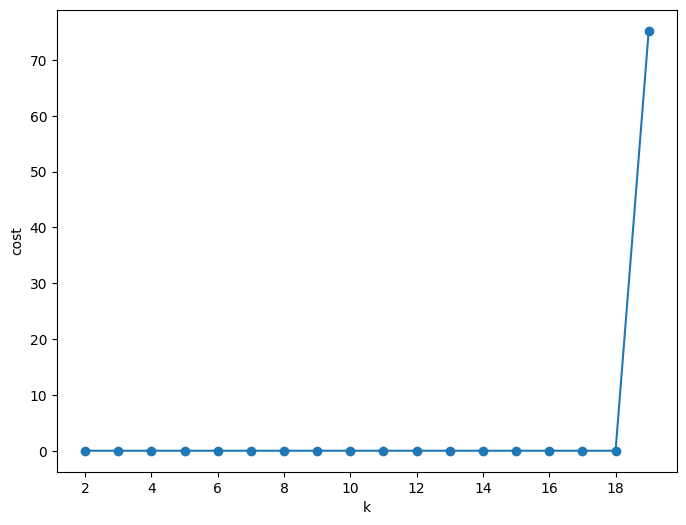

In [54]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
fig, ax=plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,20), cost[2:20], marker="o")
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show


In [64]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml.clustering import KMeans
from functools import reduce
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import pandas as pd
import time

def optimal_k(df_in, index_col, k_min, k_max, num_runs):
    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max + 1)
    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    
    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs + 1):
            kmeans = KMeans().setK(k).setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)
            predictions = model.transform(df_in)
            r_table[f'cluster_{k}_{run}'] = predictions.select('prediction').toPandas()
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)
        silh_array = np.asarray(silh_val)
        silh_lst.append(silh_array.mean())
    
    elapsed = time.time() - start
    silhouette = pd.DataFrame(list(zip(k_lst, silh_lst)), columns=['k', 'silhouette'])
    
    print('+----------------------------------------------------------------+')
    print("| The finding optimal phase took %8.0f s. |" % elapsed)
    print('+----------------------------------------------------------------+')
    
    return k_lst[np.argmax(silh_lst, axis=0)], silhouette, r_table

k_min = 3
k_max = 20
num_runs = 3
index_col = 'Customer ID'

k, sil_lst, r_table = optimal_k(scaledData, index_col, k_min, k_max, num_runs)


+----------------------------------------------------------------+
| The finding optimal phase took      163 s. |
+----------------------------------------------------------------+


In [65]:
print(k)

3


***K-MEANS CLUSTERING***

In [57]:
k=3
kmeans= KMeans().setK(k).setSeed(1)
model=kmeans.fit(scaledData)
predictions=model.transform(scaledData)
predictions.show(5,False)

+-----------+-------------------+---------------------------------------------------------------+---------------------------------------------------------------+----------+
|Customer ID|rfm                |features                                                       |features_vector                                                |prediction|
+-----------+-------------------+---------------------------------------------------------------+---------------------------------------------------------------+----------+
|17389      |[0.0,43.0,31300.08]|[0.0,0.1700404858299595,0.12540746393334334]                   |[0.0,0.1700404858299595,0.12540746393334334]                   |0         |
|13623      |[30.0,7.0,672.44]  |[0.08042895442359249,0.024291497975708502,0.017478781288030567]|[0.08042895442359249,0.024291497975708502,0.017478781288030567]|0         |
|15727      |[16.0,7.0,5178.96] |[0.04289544235924933,0.024291497975708502,0.033359298589225005]|[0.04289544235924933,0.024291497975708

In [59]:
results=rfm.join(predictions.select('Customer ID','prediction'),'Customer ID',how='left')
results.show(5)

+-----------+-------+---------+--------+----------+
|Customer ID|Recency|Frequency|Monetary|prediction|
+-----------+-------+---------+--------+----------+
|      13285|     23|        4| 2709.12|         0|
|      13623|     30|        7|  672.44|         0|
|      14570|    280|        2|  218.06|         1|
|      15727|     16|        7| 5178.96|         0|
|      16503|    106|        5| 1421.43|         2|
+-----------+-------+---------+--------+----------+
only showing top 5 rows



In [60]:
results.groupBy('prediction').agg({'Recency':'mean', 'Frequency': 'mean', 'Monetary':'mean'} ).sort(F.col('prediction')).show(5)

+----------+------------------+------------------+------------------+
|prediction|      avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+----------+------------------+------------------+------------------+
|         0|30.966337980278816|2543.0416524991438| 6.514450867052023|
|         1|296.02403846153845|407.16831730769235|1.5592948717948718|
|         2|154.40148698884758| 702.5096406443622| 2.550185873605948|
+----------+------------------+------------------+------------------+



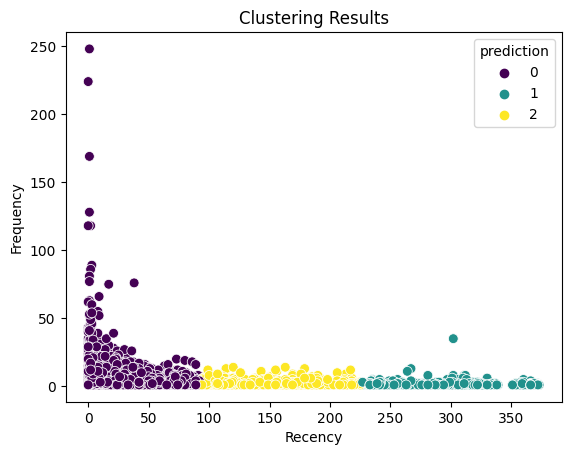

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
results_pd = results.toPandas()

# Scatter plot with different colors for each cluster
sns.scatterplot(x='Recency', y='Frequency', hue='prediction', data=results_pd, palette='viridis', s=50)
plt.title('Clustering Results')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()
